### Wine Quality

#### Data Import and Manip

In [120]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

style.use('seaborn-paper') #sets the size of the charts
style.use('fivethirtyeight')

In [28]:
# import csv
wines = pd.read_csv("winequality-red.csv", delimiter=";")
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
# save quality column as target; remove from df
target = np.array(wines.quality)
#target[:5]
wines = wines.loc[:, 'fixed acidity':'alcohol'] #removed quality column
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [17]:
# move to binary problem
# quality < 7 -> 0
# quality >= 7 -> 1
bin_target = target >= 7
bin_target = bin_target.astype(int)
print(target[:10])
print(bin_target[:10])
# check

[5 5 5 6 5 5 5 7 7 5]
[0 0 0 0 0 0 0 1 1 0]


In [35]:
# trasform feature data.frame in matrix
feature_matrix = wines.as_matrix()
#feature_matrix[:5,:5] # trasforms in a np array

#### Classification Problem

The goal is to explore a number of different methods to predict the quality of a wine $y$ (target) based on the recorder features $X$ (features). 

This is a binary classification problem.

- We will tackle the problem using mainly $\textbf{Random Forest}$. This type of algorithm is a special case of Decision Trees Algorithms. It uses an ensemlbe of trees, build with the constraint of only using a random subset $m$ of the $p$ features avaiable ($m<p$), in each tree part of the ensemble.

In [131]:
# table of target to see number of cases
unique, counts = np.unique(bin_target, return_counts=True)
classes = dict(zip(unique, counts))
classes = pd.DataFrame.from_dict(classes, orient='index') # change to DataFrame
classes.head()

,0
0,1382
1,217


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import KFold, cross_val_score

In [114]:
# single random forest (obvious overfit problem)
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(feature_matrix, bin_target)
print(rfc.feature_importances_)
print("\nmean accuracy ", rfc.score(feature_matrix, bin_target))

[0.07955846 0.09855658 0.09607625 0.06726554 0.07787805 0.05731517
 0.10628175 0.109327   0.05742591 0.12103104 0.12928426]

mean accuracy  0.9949968730456535


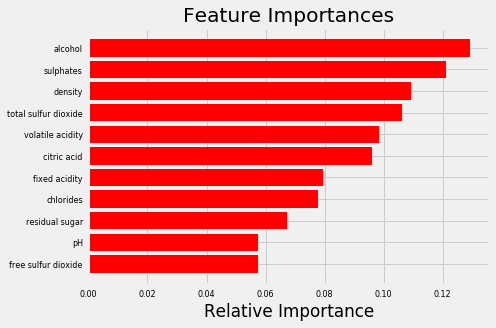

In [121]:
# importance plot from random forest
features = wines.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Random Forest with CV

In [102]:
rfc = RandomForestClassifier(n_estimators=10)
k_fold = KFold(n_splits=10)

# scoring='' to change scoring method
cross_val_score(rfc, feature_matrix, bin_target, cv=k_fold)
# this are the accuracies in all the splits

array([0.9625    , 0.925     , 0.8375    , 0.85      , 0.96875   ,
       0.8125    , 0.76875   , 0.88125   , 0.95625   , 0.89308176])

In [103]:
# repeat with different number of n_estimators, save CV_score
cv_score_list = []
for i in range(1, 40):
    rfc = RandomForestClassifier(n_estimators=i)
     
    k_fold = KFold(n_splits=10)
    cv_score = cross_val_score(rfc, feature_matrix, bin_target, cv=k_fold)
    cv_score_list.append(cv_score)

In [104]:
cv_scores = [item for sublist in cv_score_list for item in sublist]
cv_scores = pd.DataFrame(cv_scores, columns=["acc"])
cv_scores.head()

,acc
0,0.93125
1,0.89375
2,0.79375
3,0.81875
4,0.95000


Text(0.5,1,'Boxplot of 10fold CV Accuracy')

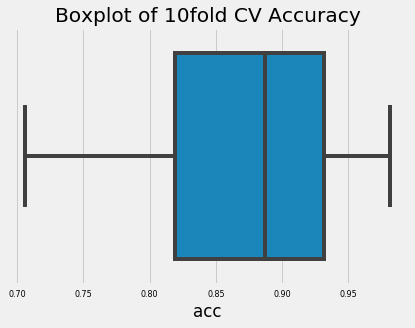

In [122]:
sns.boxplot(x = 'acc', data = cv_scores).set_title("Boxplot of 10fold CV Accuracy")

This does no help answering the question about the relationship between number of trees and accuracy with CV. It shows just the distribution of accuracies of the model.

In [141]:
perc_bad = float(classes.iloc[1]/classes.sum()) * 100
print("Percentage of Bad wines :", perc_bad, "%")

Percentage of Bad wines : 13.570981863664791 %


In [145]:
# repeat with different number of n_estimators, save CV_score with scoring = f1_score
cv_score_list = []
for i in range(1, 40):
    rfc = RandomForestClassifier(n_estimators=i)
     
    k_fold = KFold(n_splits=10)
    cv_score = cross_val_score(rfc, feature_matrix, bin_target, cv=k_fold, scoring='roc_auc')
    cv_score_list.append(cv_score)
cv_scores = [item for sublist in cv_score_list for item in sublist]
cv_scores = pd.DataFrame(cv_scores, columns=["roc_auc"])
cv_scores.head()

,roc_auc
0,0.563853
1,0.572379
2,0.670513
3,0.680578
4,0.490385


In [162]:
mean_auc = cv_scores.rolling(10).mean() 
mean_auc = mean_auc.iloc[::10, :]
mean_auc.index = range(len(mean_auc))
mean_auc.head()

,roc_auc
0,NaN
1,0.624539
2,0.712615
3,0.696481
4,0.757204


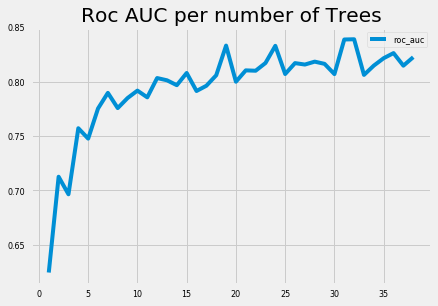

In [164]:
# show a line plot for the different AUC
# note that there are 10 values per each n_tree element (1:40 * 10) 
# we can show the mean of AUC every 10 values, so the mean grouped by n_tree value
mean_auc.plot()
plt.title("Roc AUC per number of Trees")
plt.show()

The result makes sense, at least it seems correct. As the number of trees increases, the overall $\textbf{AUC}$ increase, but this is not linear, and doesn't improve forever, as expected.

Still I dont' know if I made some mistake in my approach, since I'm not used of sklearn world. If there are any, they shouldn't be huge anyway.

I have some problems with the $\textbf{f1 score}$ calculation, I have an error that's not clear.

The model has some room for improvement, it's not great obviously since the only parameter that was changed was $n estimators$. Others possibilities are:

- number of splits
- feature eng / feature importance
- rebalance the training

### Classifier Calibration: best cutoff for probabilities